In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt


In [5]:
zip_data = pd.read_csv('https://nycdsacapstone2021.blob.core.windows.net/additionaldata/final_zip_data.csv', index_col=0)

In [8]:
zip_data.isnull().sum()

State                         0
County                        0
CBSA_Name                  1154
CountyFIPS                    0
StateFIPS                     0
Population                    0
HouseholdsPerZipCode          0
WhitePopulation               0
BlackPopulation               0
HispanicPopulation            0
AsianPopulation               0
IndianPopulation              0
OtherPopulation               0
MalePopulation                0
FemalePopulation              0
AverageHouseValue             0
IncomePerHousehold            0
MedianAge                     0
NumberOfBusinesses            0
over_65_ratio              1979
school_rating              3717
Hosp_count                 6624
Zip_count                  1154
HPI                        2750
Demand_score               3515
Supply_score               3515
listviews_vs_US            3515
med_days_on_mkt            3515
nielson_rank               3515
UE_rate                    3098
Zillow_HVF                 3256
BEA_perc

In [13]:
### Cluster zip codes to feed into redfin data
## For now, keeping numerical columns that have no null values 

cols_to_cluster = [ 'Population', 'HouseholdsPerZipCode',
       'WhitePopulation', 'BlackPopulation', 'HispanicPopulation',
       'AsianPopulation', 'IndianPopulation', 'OtherPopulation',
       'MalePopulation', 'FemalePopulation', 'AverageHouseValue']
zip_cluster = zip_data[cols_to_cluster]

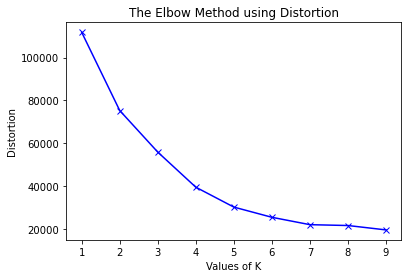

In [16]:
### Use elbow method to determine number of clusters
X = zip_cluster
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 10)
 
for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)
 
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / X.shape[0])
    inertias.append(kmeanModel.inertia_)
 
    mapping1[k] = sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / X.shape[0]
    mapping2[k] = kmeanModel.inertia_
plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

In [27]:
kmeans = KMeans(n_clusters=6, random_state=0).fit(zip_cluster)
zip_data['cluster'] = kmeans.labels_

In [31]:
zip_clusters = zip_data[['cluster']]
zip_clusters = zip_clusters.reset_index()

In [33]:
### Read in Redfin data and merge clusters in by zip code

data = pd.read_csv('./data/historical_sales.csv')
data = data.loc[(data['SALE TYPE'] == 'PAST SALE') | (data['SALE TYPE'] == 'MLS Listing')]
data = data[data['PROPERTY TYPE'] == "Single Family Residential"]

In [44]:
zip_clusters['ZipCode'] = pd.to_numeric(zip_clusters['ZipCode'])

In [47]:
data = data.loc[data['ZIP OR POSTAL CODE'].str.len() == 5]
data['ZIP OR POSTAL CODE'] = pd.to_numeric(data['ZIP OR POSTAL CODE'])

<ipython-input-47-20203363bcb9>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['ZIP OR POSTAL CODE'] = pd.to_numeric(data['ZIP OR POSTAL CODE'])


In [50]:
data = pd.merge(data, zip_clusters, how = 'left', left_on = 'ZIP OR POSTAL CODE', right_on = 'ZipCode')

In [51]:
data

,SALE TYPE,SOLD DATE,PROPERTY TYPE,ADDRESS,CITY,STATE OR PROVINCE,ZIP OR POSTAL CODE,PRICE,BEDS,BATHS,...,SOURCE,MLS#,FAVORITE,INTERESTED,LATITUDE,LONGITUDE,ZipCode_x,cluster_x,ZipCode_y,cluster_y
0,MLS Listing,NaN,Single Family Residential,1412 Lee Ln,Hopewell,VA,23860,169900.0,3.0,2.0,...,CVRMLS,2135800,N,Y,37.273772,-77.301207,23860.0,5.0,23860.0,5.0
1,MLS Listing,NaN,Single Family Residential,812 North Ave,Hopewell,VA,23860,275000.0,4.0,3.0,...,REINMLS,10412819,N,Y,37.279344,-77.316350,23860.0,5.0,23860.0,5.0
2,MLS Listing,NaN,Single Family Residential,102 S Colonial Dr,Hopewell,VA,23860,242950.0,3.0,2.0,...,CVRMLS,2135141,N,Y,37.297638,-77.319467,23860.0,5.0,23860.0,5.0
3,MLS Listing,NaN,Single Family Residential,3919 Robin Hood Dr,Hopewell,VA,23860,199000.0,4.0,2.0,...,CVRMLS,2135387,N,Y,37.303146,-77.331629,23860.0,5.0,23860.0,5.0
4,MLS Listing,NaN,Single Family Residential,3028 Grace St,Hopewell,VA,23860,229750.0,3.0,2.0,...,CVRMLS,2134281,N,Y,37.298924,-77.315952,23860.0,5.0,23860.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152597,PAST SALE,January-15-2019,Single Family Residential,401 N Daisy Ave,Henrico,VA,23075,185000.0,3.0,3.0,...,CVRMLS,1839707,N,Y,37.552895,-77.322773,23075.0,5.0,23075.0,5.0
152598,PAST SALE,February-20-2019,Single Family Residential,504 N Daisy Ave,Henrico,VA,23075,164950.0,3.0,2.0,...,CVRMLS,1900734,N,Y,37.554916,-77.321809,23075.0,5.0,23075.0,5.0
152599,PAST SALE,October-31-2019,Single Family Residential,318 N Linden Ave,Highland Springs,VA,23075,180000.0,3.0,2.0,...,CVRMLS,1930309,N,Y,37.551286,-77.316266,23075.0,5.0,23075.0,5.0
152600,PAST SALE,September-20-2019,Single Family Residential,401 Kramer Dr,Highland Springs,VA,23075,167000.0,3.0,2.0,...,CVRMLS,1921444,N,Y,37.553499,-77.323805,23075.0,5.0,23075.0,5.0
